# Modeling and Evaluation
This notebook contains model training and evaluation for the yeast ML project.

## 1. Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, StratifiedShuffleSplit

%matplotlib inline

## 2. Load Prepared Data

In [2]:
# Load preprocessed training and testing data
train_data = pd.read_csv('preprocessed_train.csv')
test_data = pd.read_csv('preprocessed_test.csv')

## 3. Baseline Model

In [3]:
# Establish a baseline model (e.g., majority class classifier)
baseline_accuracy = train_data['ProteinSite'].value_counts().max() / len(train_data)
print(f'Baseline Accuracy: {baseline_accuracy:.4f}')

Baseline Accuracy: 0.3122


## 4. Model Training and Evaluation

### 4.1 Decision Tree

#### 4.1.1 Train Decision Tree Model

In [28]:
# Initialize and train Decision Tree (drop SeqName and target)
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(train_data.drop(columns=['ProteinSite']), train_data['ProteinSite'])

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


#### 4.1.2 Evaluate Decision Tree Model

In [29]:
# Make predictions
dt_predictions = dt_classifier.predict(test_data.drop(columns=['ProteinSite']))
dt_accuracy = accuracy_score(test_data['ProteinSite'], dt_predictions)
print(f'Decision Tree Accuracy: {dt_accuracy:.4f}')

Decision Tree Accuracy: 0.5730


In [98]:
# Evaluate metrics (accuracy, precision, recall, F1-score)
y_test = test_data['ProteinSite']
y_pred = dt_predictions

acc  = accuracy_score(y_test, y_pred)
pr_w = precision_score(y_test, y_pred, average="weighted", zero_division=0)
re_w = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_w = f1_score(y_test, y_pred, average="weighted", zero_division=0)
pr_m = precision_score(y_test, y_pred, average="macro", zero_division=0)
re_m = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_m = f1_score(y_test, y_pred, average="macro", zero_division=0)

metrics_nb = pd.DataFrame({
    "model": ["DecisionTree"],
    "accuracy":[acc],
    "precision_weighted":[pr_w], "recall_weighted":[re_w], "f1_weighted":[f1_w],
    "precision_macro":[pr_m],    "recall_macro":[re_m],    "f1_macro":[f1_m]
})
display(metrics_nb)

# out = Path("outputs/naive_bayes"); out.mkdir(parents=True, exist_ok=True)
# metrics_nb.to_csv(out/"test_metrics.csv", index=False)
# pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv(out/"test_predictions.csv", index=False)

# summary = Path("outputs/results_summary.csv")
# if summary.exists():
#     df = pd.read_csv(summary); df = df[df["model"]!="NaiveBayes"]
#     pd.concat([df, metrics_nb], ignore_index=True).to_csv(summary, index=False)
# else:
#     metrics_nb.to_csv(summary, index=False)

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro
0,DecisionTree,0.572954,0.578608,0.572954,0.572827,0.546037,0.481069,0.499736


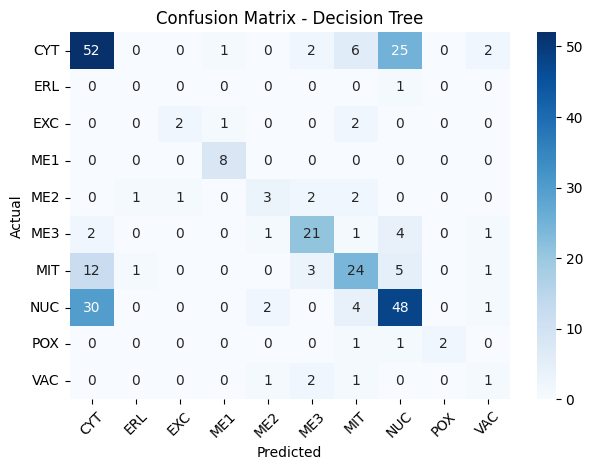

In [102]:
# Confusion matrix
labels = np.sort(y_test.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [33]:
# Classification report
print("Classification Report - Decision Tree")
print(classification_report(test_data['ProteinSite'], dt_predictions))

Classification Report - Decision Tree
              precision    recall  f1-score   support

         CYT       0.54      0.59      0.57        88
         ERL       0.00      0.00      0.00         1
         EXC       0.67      0.40      0.50         5
         ME1       0.80      1.00      0.89         8
         ME2       0.43      0.33      0.38         9
         ME3       0.70      0.70      0.70        30
         MIT       0.59      0.52      0.55        46
         NUC       0.57      0.56      0.57        85
         POX       1.00      0.50      0.67         4
         VAC       0.17      0.20      0.18         5

    accuracy                           0.57       281
   macro avg       0.55      0.48      0.50       281
weighted avg       0.58      0.57      0.57       281



#### 4.1.3 Hyperparameter Tuning - Decision Tree

In [34]:
# Grid search for hyperparameter tuning
# param_grid = {
#     'max_depth': [5, 6, 7, 8, 9],
#     'min_samples_split': [2, 4, 6, 5, 10],
#     'min_samples_leaf': [1, 2, 3, 5, 8, 10],
#     'criterion': ['gini', 'entropy']
# }

param_grid = {
    'max_depth': [None, 2, 3, 4, 5, 9, 10],
    'min_samples_split': range(2,10),
    'min_samples_leaf': [1, 2, 3, 5, 8, 10],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(estimator=dt_classifier, param_grid=param_grid, cv=4, n_jobs=-1, scoring='f1_macro')
grid_search.fit(train_data.drop(columns=['ProteinSite']), train_data['ProteinSite'])
print(f'Best parameters from Grid Search: {grid_search.best_params_}')

Best parameters from Grid Search: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3}


In [35]:

best_params = grid_search.best_params_
tuned_dt_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=10, random_state=42)
tuned_dt_classifier.fit(train_data.drop(columns=['ProteinSite']), train_data['ProteinSite'])

y_pred = tuned_dt_classifier.predict(test_data.drop(columns=['ProteinSite']))
y_test = test_data['ProteinSite']
acc  = accuracy_score(y_test, y_pred)
pr_w = precision_score(y_test, y_pred, average="weighted", zero_division=0)
re_w = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_w = f1_score(y_test, y_pred, average="weighted", zero_division=0)
pr_m = precision_score(y_test, y_pred, average="macro", zero_division=0)
re_m = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_m = f1_score(y_test, y_pred, average="macro", zero_division=0)

metrics_nb = pd.DataFrame({
    "model": ["DecisionTree"],
    "accuracy":[acc],
    "precision_weighted":[pr_w], "recall_weighted":[re_w], "f1_weighted":[f1_w],
    "precision_macro":[pr_m],    "recall_macro":[re_m],    "f1_macro":[f1_m]
})
display(metrics_nb)

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro
0,DecisionTree,0.576512,0.56922,0.576512,0.564984,0.451777,0.431857,0.433008


#### 4.1.4 Learning Curves - Decision Tree

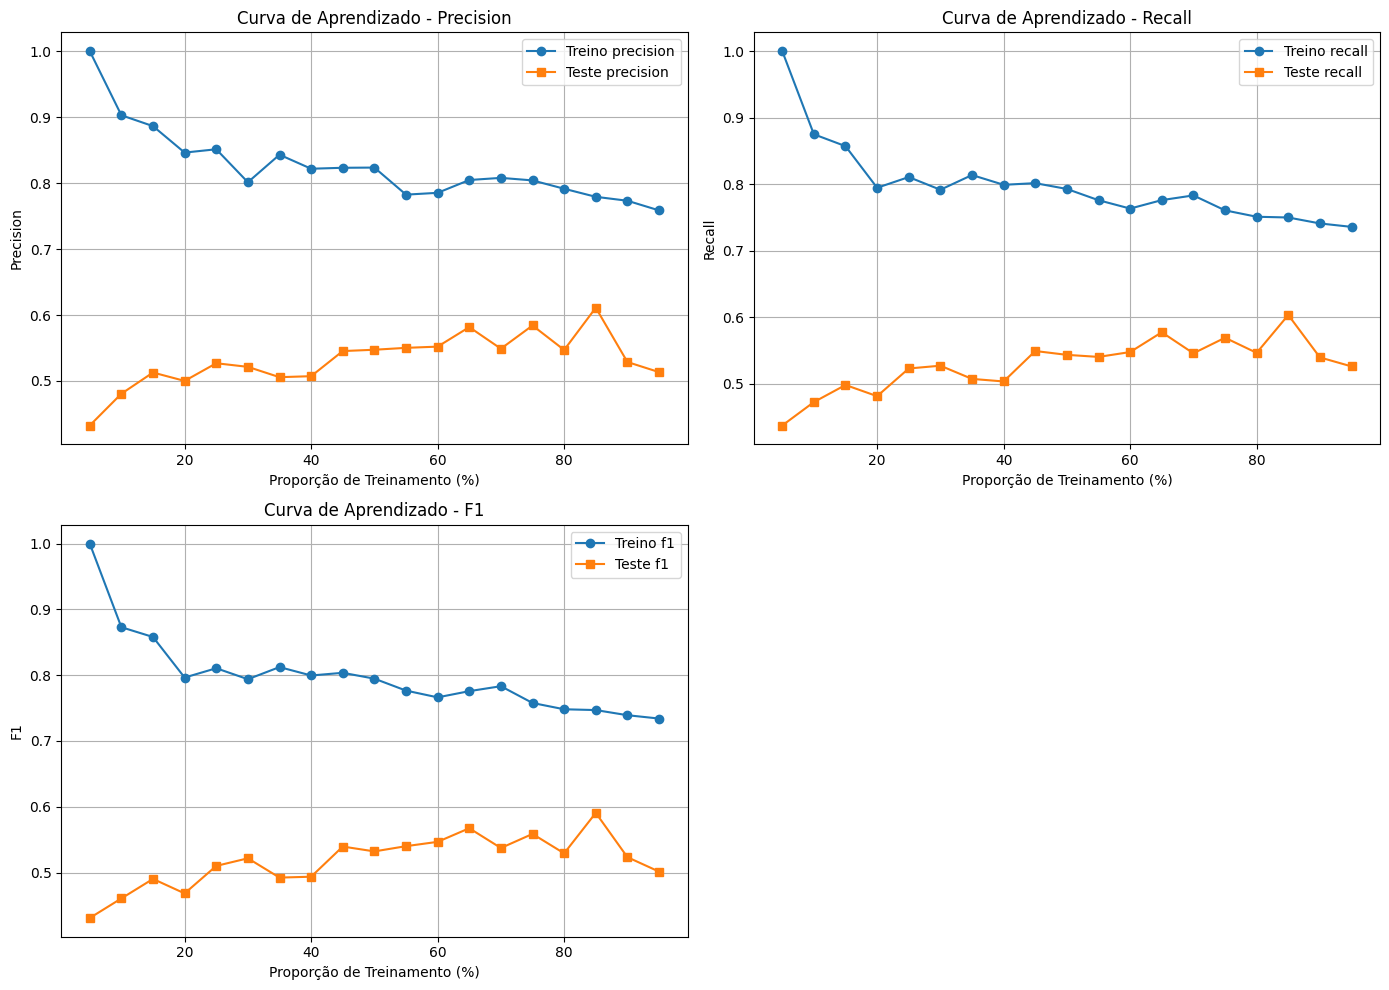

In [333]:
#Learning curve analysis
best_params = grid_search.best_params_

# Inicializa listas para armazenar resultados
train_sizes = np.arange(0.05, 1.00, 0.05)
metrics_train = {'precision': [], 'recall': [], 'f1': []}
metrics_test  = {'precision': [], 'recall': [], 'f1': []}

# Extrai X e y
X = train_data.drop(columns=['ProteinSite'])
y = train_data['ProteinSite']

# Estratificação para manter a proporção das classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)

for size in train_sizes:
    # Define proporção de treino e teste
    test_size = 1 - size
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Treina o modelo com os melhores hiperparâmetros
    dt_best = DecisionTreeClassifier(**best_params, random_state=42)
    dt_best.fit(X_train, y_train)
    
    # Predições
    y_train_pred = dt_best.predict(X_train)
    y_test_pred  = dt_best.predict(X_test)
    
    # Métricas no treino
    metrics_train['precision'].append(precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
    metrics_train['recall'].append(recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
    metrics_train['f1'].append(f1_score(y_train, y_train_pred, average='weighted', zero_division=0))
    
    # Métricas no teste
    metrics_test['precision'].append(precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
    metrics_test['recall'].append(recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
    metrics_test['f1'].append(f1_score(y_test, y_test_pred, average='weighted', zero_division=0))

# === Plot das curvas de aprendizado ===
plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics_train.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot(train_sizes * 100, metrics_train[metric], 'o-', label=f'Treino {metric}')
    plt.plot(train_sizes * 100, metrics_test[metric], 's-', label=f'Teste {metric}')
    plt.title(f'Curva de Aprendizado - {metric.capitalize()}')
    plt.xlabel('Proporção de Treinamento (%)')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


### 4.2 Naive Bayes

#### 4.2.1 Train Naive Bayes Model

In [78]:
# Initialize and train Naive Bayes
target_col = "ProteinSite"
id_cols = ["SeqName"] if "SeqName" in train_data.columns else []

X_train = train_data.drop(columns=id_cols + [target_col])
y_train = train_data[target_col]

X_test  = test_data.drop(columns=[c for c in id_cols + [target_col] if c in test_data.columns])
y_test  = test_data[target_col]

nb_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("nb", GaussianNB())
])

nb_pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('nb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,priors,None
,var_smoothing,1e-09


#### 4.2.2 Evaluate Naive Bayes Model

In [104]:
# Make predictions
model_nb = grid_nb.best_estimator_ if "grid_nb" in globals() else nb_pipeline
print("Using:", "grid_nb.best_estimator_" if "grid_nb" in globals() else "nb_pipeline (baseline)")

y_pred  = model_nb.predict(X_test)
y_proba = model_nb.predict_proba(X_test)

Using: grid_nb.best_estimator_


In [105]:
# Evaluate metrics (accuracy, precision, recall, F1-score)
# baseline
majority = y_train.value_counts().idxmax()
baseline_acc = accuracy_score(y_test, np.full_like(y_test, majority))

acc  = accuracy_score(y_test, y_pred)
pr_w = precision_score(y_test, y_pred, average="weighted", zero_division=0)
re_w = recall_score(y_test, y_pred, average="weighted", zero_division=0)
f1_w = f1_score(y_test, y_pred, average="weighted", zero_division=0)
pr_m = precision_score(y_test, y_pred, average="macro", zero_division=0)
re_m = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1_m = f1_score(y_test, y_pred, average="macro", zero_division=0)

metrics_nb = pd.DataFrame({
    "model": ["NaiveBayes"],
    "accuracy":[acc],
    "precision_weighted":[pr_w], "recall_weighted":[re_w], "f1_weighted":[f1_w],
    "precision_macro":[pr_m],    "recall_macro":[re_m],    "f1_macro":[f1_m],
    "baseline_accuracy":[baseline_acc]
})
display(metrics_nb)

out = Path("outputs/naive_bayes"); out.mkdir(parents=True, exist_ok=True)
metrics_nb.to_csv(out/"test_metrics.csv", index=False)
pd.DataFrame({"y_true": y_test, "y_pred": y_pred}).to_csv(out/"test_predictions.csv", index=False)

summary = Path("outputs/results_summary.csv")
if summary.exists():
    df = pd.read_csv(summary); df = df[df["model"]!="NaiveBayes"]
    pd.concat([df, metrics_nb], ignore_index=True).to_csv(summary, index=False)
else:
    metrics_nb.to_csv(summary, index=False)

,model,accuracy,precision_weighted,recall_weighted,f1_weighted,precision_macro,recall_macro,f1_macro,baseline_accuracy
0,NaiveBayes,0.615658,0.629593,0.615658,0.605946,0.612316,0.573763,0.529605,0.313167


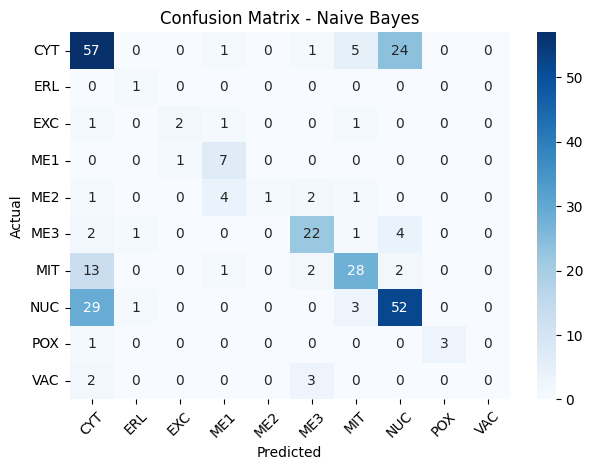

In [106]:
# Confusion matrix - Naive Bayes
labels = np.sort(y_train.unique())
cm = confusion_matrix(y_test, y_pred, labels=labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Naive Bayes')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [82]:
# Classification report
rep = classification_report(y_test, y_pred, digits=3, zero_division=0)
print(rep)
# with open("outputs/naive_bayes/classification_report.txt","w") as f:
#     f.write(rep)

              precision    recall  f1-score   support

         CYT      0.000     0.000     0.000        88
         ERL      1.000     1.000     1.000         1
         EXC      0.176     0.600     0.273         5
         ME1      0.467     0.875     0.609         8
         ME2      0.000     0.000     0.000         9
         ME3      0.406     0.867     0.553        30
         MIT      0.000     0.000     0.000        46
         NUC      0.600     0.212     0.313        85
         POX      1.000     0.750     0.857         4
         VAC      0.013     0.400     0.026         5

    accuracy                          0.214       281
   macro avg      0.366     0.470     0.363       281
weighted avg      0.259     0.214     0.192       281



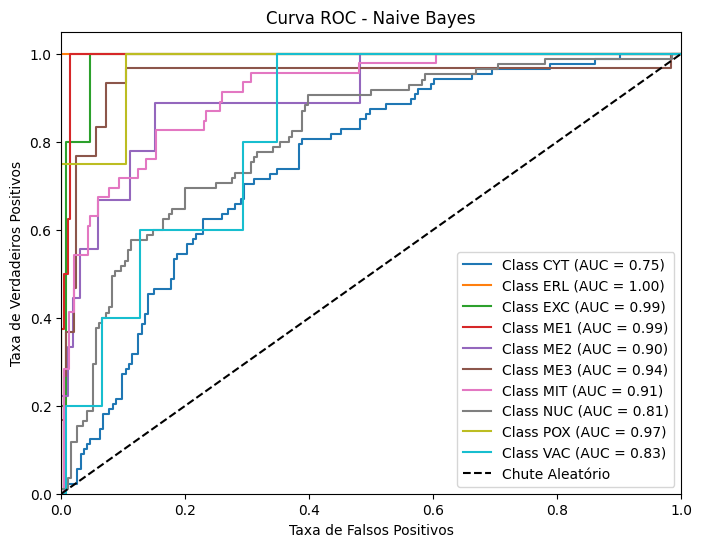

In [150]:
# Plot ROC curve
y_test_binarized = pd.get_dummies(y_test, columns=labels)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i, label in enumerate(labels):
    fpr[label], tpr[label], _ = roc_curve(y_test_binarized.iloc[:, i], y_proba[:, i])
    roc_auc[label] = roc_auc_score(y_test_binarized.iloc[:, i], y_proba[:, i])
plt.figure(figsize=(8, 6))
for label in labels:
    plt.plot(fpr[label], tpr[label], label=f'Class {label} (AUC = {roc_auc[label]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chute Aleatório')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - Naive Bayes')
plt.legend(loc='lower right')
plt.show()

#### 4.2.3 Hyperparameter Tuning - Naive Bayes

In [83]:
# Grid search for hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, GridSearchCV

param_grid_nb = {"nb__var_smoothing": np.logspace(-12, 10, 100)}
cv_nb = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_nb = GridSearchCV(
    estimator=Pipeline([("scaler", StandardScaler()), ("nb", GaussianNB())]),
    param_grid=param_grid_nb,
    scoring="f1_macro",
    cv=cv_nb,
    n_jobs=-1,
    return_train_score=True
)
grid_nb.fit(X_train, y_train)

print("Best params:", grid_nb.best_params_)
print(f"CV mean F1-macro: {grid_nb.best_score_:.4f}")

# out = Path("outputs/naive_bayes"); out.mkdir(parents=True, exist_ok=True)
# pd.DataFrame(grid_nb.cv_results_).to_csv(out/"cv_results.csv", index=False)
# pd.DataFrame({"best_params":[grid_nb.best_params_],
#               "cv_f1_macro":[grid_nb.best_score_]}).to_csv(out/"best_params.csv", index=False)


d:\programming\25.2\am\yeast-ML-project\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best params: {'nb__var_smoothing': np.float64(1.0)}
CV mean F1-macro: 0.5004


4.2.4 Learning curves - Naive Bayes

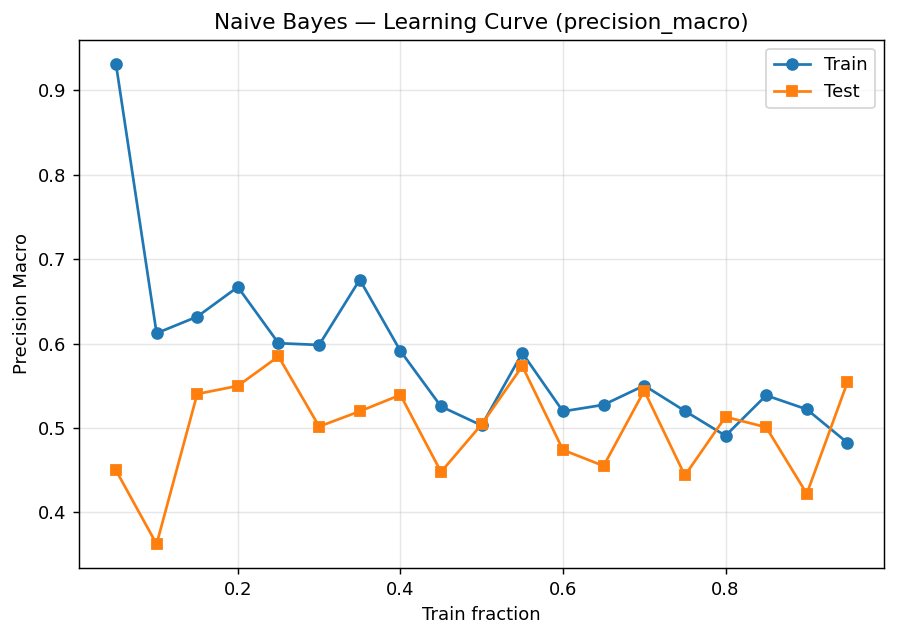

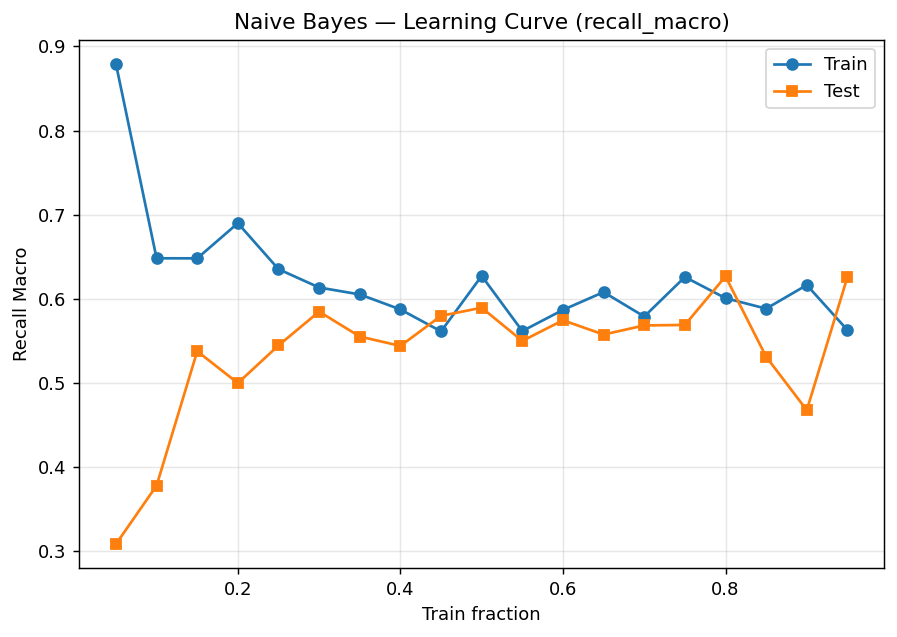

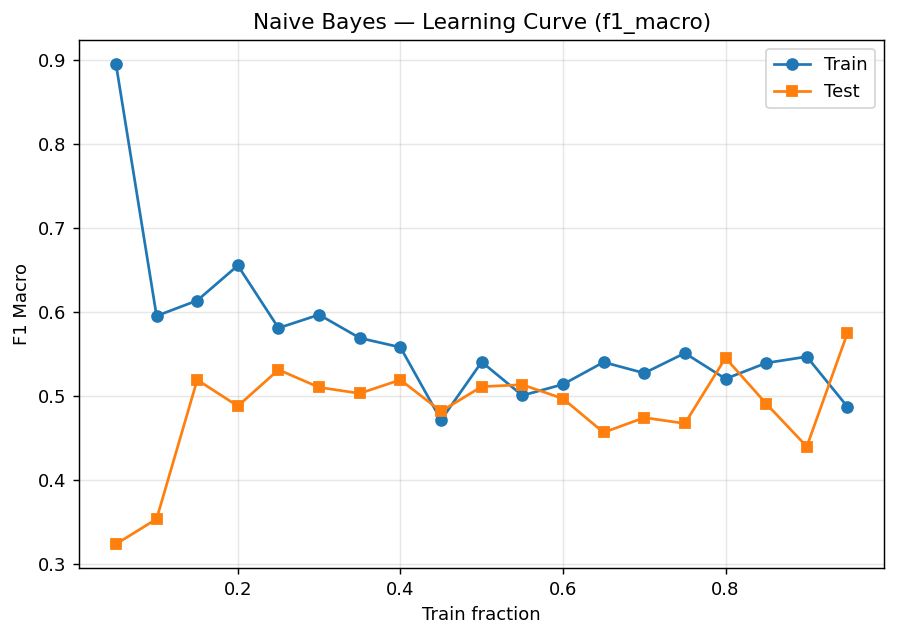

In [152]:
# Stratified train/test splits from 5% to 95%
from sklearn.model_selection import StratifiedShuffleSplit

# Use the tuned model. otherwise, use the baseline pipeline
model_nb_for_curves = grid_nb.best_estimator_ if "grid_nb" in globals() else nb_pipeline

X_all = pd.concat([X_train, X_test], axis=0).reset_index(drop=True)
y_all = pd.concat([y_train, y_test], axis=0).reset_index(drop=True)

def eval_metrics(y_true, y_pred):
    return {
        "precision_macro": precision_score(y_true, y_pred, average="macro", zero_division=0),
        "recall_macro": recall_score(y_true, y_pred, average="macro", zero_division=0),
        "f1_macro": f1_score(y_true, y_pred, average="macro", zero_division=0),
    }

rows = []
train_fracs = np.arange(0.05, 0.951, 0.05)  # 5%, 10%, ..., 95%
for i, train_frac in enumerate(train_fracs, start=1):
    test_frac = 1.0 - train_frac
    sss = StratifiedShuffleSplit(
        n_splits=1, train_size=train_frac, test_size=test_frac, random_state=42 + i
    )
    (idx_tr, idx_te), = sss.split(X_all, y_all)

    X_tr, y_tr = X_all.iloc[idx_tr], y_all.iloc[idx_tr]
    X_te, y_te = X_all.iloc[idx_te], y_all.iloc[idx_te]

    model = model_nb_for_curves
    model.fit(X_tr, y_tr)

    yhat_tr = model.predict(X_tr)
    yhat_te = model.predict(X_te)

    m_tr = eval_metrics(y_tr, yhat_tr)
    m_te = eval_metrics(y_te, yhat_te)

    rows.append({
        "train_fraction": train_frac,
        "test_fraction": test_frac,
        **{f"train_{k}": v for k, v in m_tr.items()},
        **{f"test_{k}": v for k, v in m_te.items()},
    })

lc_df = pd.DataFrame(rows)

out_dir = Path("outputs/naive_bayes")
out_dir.mkdir(parents=True, exist_ok=True)
lc_df.to_csv(out_dir / "learning_curves_5to95.csv", index=False)

# Helper: consistent line plot
def plot_metric(df, metric):
    plt.figure(figsize=(7, 5), dpi=130)
    plt.plot(df["train_fraction"], df[f"train_{metric}"], marker="o", label="Train")
    plt.plot(df["train_fraction"], df[f"test_{metric}"],  marker="s", label="Test")
    plt.xlabel("Train fraction")
    plt.ylabel(metric.replace("_", " ").title())
    plt.title(f"Naive Bayes — Learning Curve ({metric})")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.savefig(out_dir / f"learning_curve_{metric}.png", bbox_inches="tight")
    plt.show()

for metric in ["precision_macro", "recall_macro", "f1_macro"]:
    plot_metric(lc_df, metric)

# print("Saved:", out_dir / "learning_curves_5to95.csv")

### 4.3 Logistic Regression

#### 4.3.1 Train Logistic Regression Model

In [153]:
# Initialize and train Logistic Regression
# Make predictions

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

df_train = pd.read_csv("preprocessed_train.csv")
df_test = pd.read_csv("preprocessed_test.csv")

target_column = 'ProteinSite'

X_train = df_train.drop(columns=[target_column])
y_train = df_train[target_column]

X_test = df_test.drop(columns=[target_column])
y_test = df_test[target_column]

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print("Encoded train classes:", le.classes_)

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


log_reg = LogisticRegression(
    solver='lbfgs', 
    max_iter=1000,
    random_state=42
)

log_reg.fit(X_train_scaled, y_train_encoded)

Encoded train classes: ['CYT' 'ERL' 'EXC' 'ME1' 'ME2' 'ME3' 'MIT' 'NUC' 'POX' 'VAC']


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


#### 4.3.2 Evaluate Logistic Regression Model

In [154]:
# Evaluate metrics (accuracy, precision, recall, F1-score)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_encoded, y_pred)
class_names = le.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

fig, ax = plt.subplots(figsize=(7, 7))

disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [ ]:
# Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_encoded, log_reg.predict(X_test_scaled))
class_names = le.classes_

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)

fig, ax = plt.subplots(figsize=(7, 7))

disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [155]:
# Classification report

from sklearn.metrics import classification_report

print("Classification Report - Logistic Regression")
print(classification_report(y_test_encoded, log_reg.predict(X_test_scaled), target_names=le.classes_, zero_division=0))

#### 4.3.3 Hyperparameter Tuning - Logistic Regression

In [156]:
# Grid search for hyperparameter tuning
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, classification_report
from Imbalanced-learn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from collections import Counter
import time

# safe smote for small classes
min_class_count = min(Counter(y_train_encoded).values())
smote = SMOTE(k_neighbors=1, random_state=42)

# Logistic Regression wrapped for multiclass
base_log_reg = OneVsRestClassifier(
    LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000)
)

# pipeline
pipeline = ImbPipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', smote),
    ('logreg', base_log_reg)
])

# hyperparameter grid
param_grid = [
    # liblinear: suporta l1 e l2
    {
        'logreg__estimator__solver': ['liblinear'],
        'logreg__estimator__penalty': ['l1','l2'],
        'logreg__estimator__C': [0.01, 0.1, 1, 10],
        'logreg__estimator__multi_class': ['ovr'],
        'logreg__estimator__max_iter': [1000, 2000]
    },
    # lbfgs: suporta apenas l2
    {
        'logreg__estimator__solver': ['lbfgs'],
        'logreg__estimator__penalty': ['l2'],
        'logreg__estimator__C': [0.01, 0.1, 1, 10],
        'logreg__estimator__multi_class': ['ovr'],
        'logreg__estimator__max_iter': [1000, 2000]
    },
    # saga: suporta l1, l2 e elasticnet
    {
        'logreg__estimator__solver': ['saga'],
        'logreg__estimator__penalty': ['l1','l2','elasticnet'],
        'logreg__estimator__C': [0.01, 0.1, 1, 10],
        'logreg__estimator__l1_ratio': [0,0.5,1],  # só usado se elasticnet
        'logreg__estimator__multi_class': ['ovr'],
        'logreg__estimator__max_iter': [1000, 2000]
    }
]

# Cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# GridSearch
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='',     
    cv=cv,
    n_jobs=-1,
    verbose=2,
    refit=True,           
    error_score='raise'
)
grid_search.fit(X_train_scaled, y_train_encoded)

print(f"Best Score (Weighted Metric): {grid_search.best_score_:.4f}")
print("Best Hyperparameters:")
for k, v in grid_search.best_params_.items():
    print(f" {k}: {v}")

# test evaluation
y_pred = grid_search.best_estimator_.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test_encoded, y_pred, zero_division=0))

#### 4.3.4 Plot Curves

In [157]:
fractions = np.arange(0.05, 1.0, 0.05)  # 5% a 95%

metrics = {
    'fraction': [],
    'accuracy_train': [], 'accuracy_test': [],
    'f1_train': [], 'f1_test': [],
    'balanced_acc_train': [], 'balanced_acc_test': [],
    'precision_train': [], 'precision_test': [],
    'recall_train': [], 'recall_test': []
}

for frac in fractions:
    X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(
        X_train_scaled, y_train_encoded,
        train_size=frac,
        stratify=y_train_encoded,
        random_state=42
    )
    
    min_class_count = min(Counter(y_train_part).values())
    
    if min_class_count >= 2:
        smote = SMOTE(k_neighbors=min(min_class_count-1, 5), random_state=42)
        model = ImbPipeline([
            ('scaler', StandardScaler()),
            ('smote', smote),
            ('logreg', base_logreg)
        ])
    else:
        model = ImbPipeline([
            ('scaler', StandardScaler()),
            ('logreg', base_logreg)
        ])
    
    model.fit(X_train_part, y_train_part)
    
    # métricas
    y_train_pred = model.predict(X_train_part)
    y_test_pred = model.predict(X_test_part)
    
    metrics['fraction'].append(frac*100)  # armazenando como porcentagem
    
    metrics['accuracy_train'].append(accuracy_score(y_train_part, y_train_pred))
    metrics['accuracy_test'].append(accuracy_score(y_test_part, y_test_pred))
    
    metrics['f1_train'].append(f1_score(y_train_part, y_train_pred, average='macro'))
    metrics['f1_test'].append(f1_score(y_test_part, y_test_pred, average='macro'))
    
    metrics['balanced_acc_train'].append(balanced_accuracy_score(y_train_part, y_train_pred))
    metrics['balanced_acc_test'].append(balanced_accuracy_score(y_test_part, y_test_pred))
    
    metrics['precision_train'].append(precision_score(y_train_part, y_train_pred, average='macro', zero_division=0))
    metrics['precision_test'].append(precision_score(y_test_part, y_test_pred, average='macro', zero_division=0))
    
    metrics['recall_train'].append(recall_score(y_train_part, y_train_pred, average='macro', zero_division=0))
    metrics['recall_test'].append(recall_score(y_test_part, y_test_pred, average='macro', zero_division=0))

# Plot
metric_names = ['accuracy', 'f1', 'balanced_acc', 'precision', 'recall']
critical_frac = 35  # ponto crítico em porcentagem

for name in metric_names:
    plt.figure(figsize=(8,5))
    plt.plot(metrics['fraction'], metrics[f'{name}_train'], label='Train', marker='o')
    plt.plot(metrics['fraction'], metrics[f'{name}_test'], label='Test', marker='x')
    plt.axvline(x=critical_frac, color='red', linestyle='--', label='Critical Point (~35%)')
    plt.xlabel('Training Set (%)')
    plt.ylabel(name.replace('_',' ').title())
    plt.title(f'Learning Curve - {name.replace("_"," ").title()}')
    plt.legend()
    plt.grid(True)
    plt.show()


### 4.4 K-Nearest Neighbors (KNN)

#### 4.4.1 Train KNN Model

In [208]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(
    n_neighbors=5,      
    weights='uniform',
    metric='euclidean'
)

knn.fit(train_data.drop('ProteinSite', axis=1), train_data['ProteinSite'])



,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'euclidean'
,metric_params,None
,n_jobs,None


#### 4.4.2 Evaluate KNN Model

In [198]:
from sklearn.metrics import classification_report

y_pred_knn = knn.predict(test_data.drop('ProteinSite', axis=1))

print("Classification Report - KNN")
print(classification_report(test_data['ProteinSite'], y_pred_knn, digits=2, zero_division=0))


Classification Report - KNN
              precision    recall  f1-score   support

         CYT       0.49      0.67      0.57        88
         ERL       1.00      1.00      1.00         1
         EXC       1.00      0.60      0.75         5
         ME1       0.64      0.88      0.74         8
         ME2       0.44      0.44      0.44         9
         ME3       0.72      0.60      0.65        30
         MIT       0.66      0.54      0.60        46
         NUC       0.62      0.52      0.56        85
         POX       1.00      0.75      0.86         4
         VAC       0.00      0.00      0.00         5

    accuracy                           0.58       281
   macro avg       0.66      0.60      0.62       281
weighted avg       0.59      0.58      0.58       281



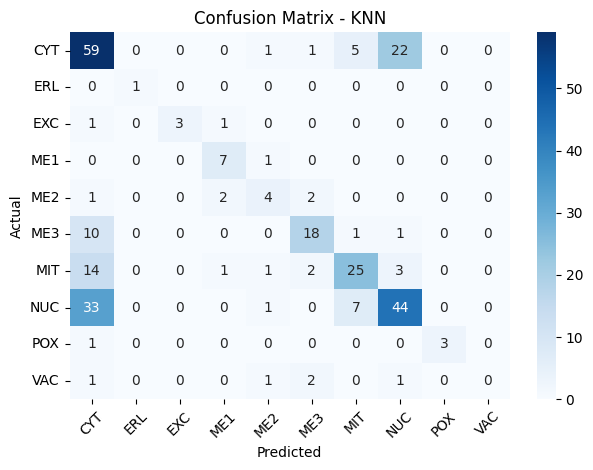

In [199]:
labels = np.sort(test_data['ProteinSite'].unique())
cm = confusion_matrix(test_data['ProteinSite'], y_pred_knn, labels=labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - KNN')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### 4.4.3 Hyperparameter Tuning - KNN

In [215]:

pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

param_grid_knn = {
    'knn__n_neighbors': range(1, 15, 2),
    'knn__weights': ['uniform', 'distance'],
    'knn__metric': ['euclidean'],
}


grid_search_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    scoring='f1_macro',
    cv=StratifiedKFold(n_splits=5),
    n_jobs=-1
)


grid_search_knn.fit(train_data.drop('ProteinSite', axis=1), train_data['ProteinSite'])

print("Best F1 Macro:", grid_search_knn.best_score_)
print("Best Hyperparameters:", grid_search_knn.best_params_)

y_pred_knn = grid_search_knn.predict(test_data.drop('ProteinSite', axis=1))
print("\nClassification Report - KNN:")
print(classification_report(test_data['ProteinSite'], y_pred_knn, digits=2, zero_division=0))


Best F1 Macro: 0.5390817534196805
Best Hyperparameters: {'knn__metric': 'euclidean', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

Classification Report - KNN:
              precision    recall  f1-score   support

         CYT       0.47      0.70      0.56        88
         ERL       1.00      1.00      1.00         1
         EXC       0.43      0.60      0.50         5
         ME1       0.64      0.88      0.74         8
         ME2       0.43      0.33      0.38         9
         ME3       0.79      0.63      0.70        30
         MIT       0.63      0.41      0.50        46
         NUC       0.59      0.46      0.52        85
         POX       1.00      0.50      0.67         4
         VAC       0.00      0.00      0.00         5

    accuracy                           0.55       281
   macro avg       0.60      0.55      0.56       281
weighted avg       0.57      0.55      0.54       281



d:\programming\25.2\am\yeast-ML-project\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


#### 4.4.4 Plot Curves

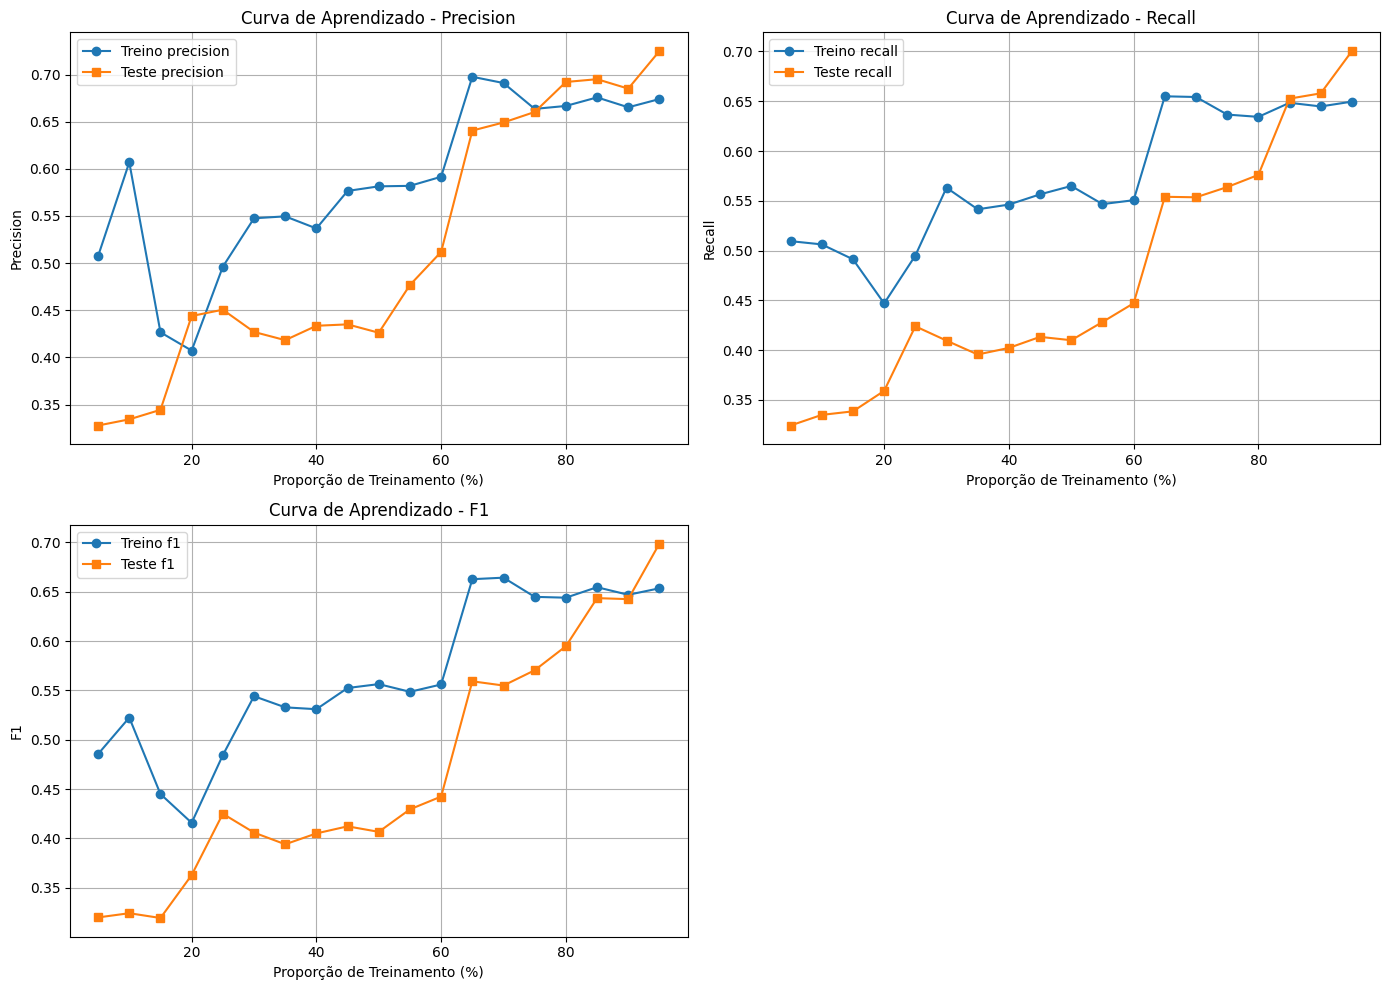

In [ ]:
# Plot curves for KNN
fractions = np.arange(0.05, 1.0, 0.05)  # 5% a 95%

X = train_data.drop(columns=['ProteinSite'])
y = train_data['ProteinSite']

train_sizes = np.arange(0.05, 1.00, 0.05)
metrics_train = {'precision': [], 'recall': [], 'f1': []}
metrics_test  = {'precision': [], 'recall': [], 'f1': []}

for size in train_sizes:
    test_size = 1 - size
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Extrai apenas os parâmetros do KNN dos melhores parâmetros
    knn_params = {k.replace('knn__', ''): v for k, v in grid_search_knn.best_params_.items() if k.startswith('knn__')}
    knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean', weights='uniform')
    
    # Aplica scaling nos dados
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    knn_model.fit(X_train_scaled, y_train)
    
    y_train_pred = knn_model.predict(X_train_scaled)
    y_test_pred  = knn_model.predict(X_test_scaled)
    
    metrics_train['precision'].append(precision_score(y_train, y_train_pred, average='macro', zero_division=0))
    metrics_train['recall'].append(recall_score(y_train, y_train_pred, average='macro', zero_division=0))
    metrics_train['f1'].append(f1_score(y_train, y_train_pred, average='macro', zero_division=0))

    metrics_test['precision'].append(precision_score(y_test, y_test_pred, average='macro', zero_division=0))
    metrics_test['recall'].append(recall_score(y_test, y_test_pred, average='macro', zero_division=0))
    metrics_test['f1'].append(f1_score(y_test, y_test_pred, average='macro', zero_division=0))

# Plot das curvas de aprendizado
plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics_train.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot(train_sizes * 100, metrics_train[metric], 'o-', label=f'Treino {metric}')
    plt.plot(train_sizes * 100, metrics_test[metric], 's-', label=f'Teste {metric}')
    plt.title(f'Curva de Aprendizado - {metric.capitalize()}')
    plt.xlabel('Proporção de Treinamento (%)')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

#Show metrics_test and train
print("Train Metrics:", metrics_train)
print("Test Metrics:", metrics_test)

### 4.5 Random Forest

In [119]:
param_grid = {
    'n_estimators': [100, 165, 200],
    'max_depth': [10, 15, 19, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6]
}

rf_classifier = RandomForestClassifier(random_state=42)

# rf_baseline_prediction = rf_classifier.fit(train_data.drop(columns=['ProteinSite']), train_data['ProteinSite']).predict(test_data.drop(columns=['ProteinSite']))
# rf_baseline_f1 = f1_score(test_data['ProteinSite'], rf_baseline_prediction, average='macro')
# rf_baseline_precision = precision_score(test_data['ProteinSite'], rf_baseline_prediction, average='macro')
# rf_baseline_recall = recall_score(test_data['ProteinSite'], rf_baseline_prediction, average='macro')
# print(f'Random Forest Baseline F1 Score: {rf_baseline_f1:.4f}')
# print(f'Random Forest Baseline Precision: {rf_baseline_precision:.4f}')
# print(f'Random Forest Baseline Recall: {rf_baseline_recall:.4f}')

# #weighted
# rf_baseline_f1_weighted = f1_score(test_data['ProteinSite'], rf_baseline_prediction, average='weighted')
# rf_baseline_precision_weighted = precision_score(test_data['ProteinSite'], rf_baseline_prediction, average='weighted')
# rf_baseline_recall_weighted = recall_score(test_data['ProteinSite'], rf_baseline_prediction, average='weighted')
# print(f'Random Forest Baseline F1 Score (weighted): {rf_baseline_f1_weighted:.4f}')
# print(f'Random Forest Baseline Precision (weighted): {rf_baseline_precision_weighted:.4f}')
# print(f'Random Forest Baseline Recall (weighted): {rf_baseline_recall_weighted:.4f}')

grid_search_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='accuracy'
)
grid_search_rf.fit(train_data.drop(columns=['ProteinSite']), train_data['ProteinSite'])

print(f'Best parameters from Grid Search (Random Forest): {grid_search_rf.best_params_}')

d:\programming\25.2\am\yeast-ML-project\.venv\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Best parameters from Grid Search (Random Forest): {'max_depth': 19, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 165}


In [118]:
best_rf = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
best_rf.fit(train_data.drop(columns=['ProteinSite']), train_data['ProteinSite'])

,n_estimators,165
,criterion,'gini'
,max_depth,19
,min_samples_split,5
,min_samples_leaf,2
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


#### 4.5.2 Evaluate Random Forest Model

In [120]:
# Make predictions
best_rf = grid_search_rf.best_estimator_
rf_predictions = best_rf.predict(test_data.drop(columns=['ProteinSite']))

In [139]:
# Evaluate metrics (accuracy, precision, recall, F1-score)

# macro avarages
rf_f1_macro = f1_score(test_data['ProteinSite'], rf_predictions, average='macro')
rf_precision_macro = precision_score(test_data['ProteinSite'], rf_predictions, average='macro', zero_division=0)
rf_recall_macro = recall_score(test_data['ProteinSite'], rf_predictions, average='macro', zero_division=0)

rf_accuracy = accuracy_score(test_data['ProteinSite'], rf_predictions)
rf_precision = precision_score(test_data['ProteinSite'], rf_predictions, average='weighted', zero_division=0)
rf_recall = recall_score(test_data['ProteinSite'], rf_predictions, average='weighted', zero_division=0)
rf_f1 = f1_score(test_data['ProteinSite'], rf_predictions, average='weighted', zero_division=0)

print(f'\nRandom Forest Macro Accuracy:  {rf_accuracy:.4f}')
print(f'Random Forest Macro Precision: {rf_precision_macro:.4f}')
print(f'Random Forest Macro Recall:    {rf_recall_macro:.4f}')
print(f'Random Forest Macro F1-score:  {rf_f1_macro:.4f}')

print(f'\nRandom Forest Weighted Accuracy:  {rf_accuracy:.4f}')
print(f'Random Forest Weighted Precision: {rf_precision:.4f}')
print(f'Random Forest Weighted Recall:    {rf_recall:.4f}')


Random Forest Macro Accuracy:  0.6548
Random Forest Macro Precision: 0.7027
Random Forest Macro Recall:    0.6151
Random Forest Macro F1-score:  0.6342

Random Forest Weighted Accuracy:  0.6548
Random Forest Weighted Precision: 0.6533
Random Forest Weighted Recall:    0.6548


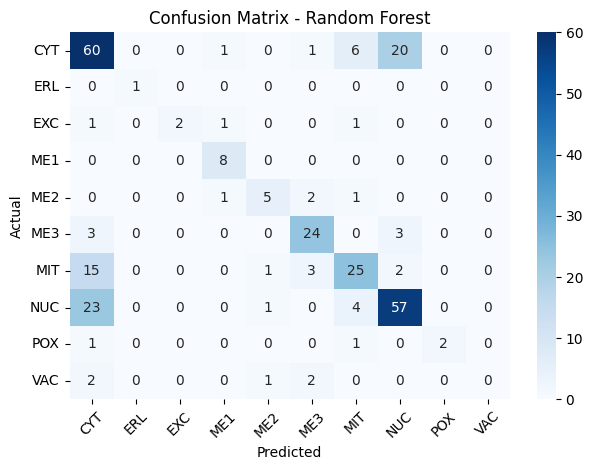

In [149]:
# Confusion matrix - Random Forest

labels = np.sort(test_data['ProteinSite'].unique())
cm = confusion_matrix(test_data['ProteinSite'], rf_predictions, labels=labels)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [140]:
# Classification report
print("\nClassification Report - Random Forest")
print(classification_report(test_data['ProteinSite'], rf_predictions))


Classification Report - Random Forest
              precision    recall  f1-score   support

         CYT       0.57      0.68      0.62        88
         ERL       1.00      1.00      1.00         1
         EXC       1.00      0.40      0.57         5
         ME1       0.73      1.00      0.84         8
         ME2       0.62      0.56      0.59         9
         ME3       0.75      0.80      0.77        30
         MIT       0.66      0.54      0.60        46
         NUC       0.70      0.67      0.68        85
         POX       1.00      0.50      0.67         4
         VAC       0.00      0.00      0.00         5

    accuracy                           0.65       281
   macro avg       0.70      0.62      0.63       281
weighted avg       0.65      0.65      0.65       281



d:\programming\25.2\am\yeast-ML-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming\25.2\am\yeast-ML-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\programming\25.2\am\yeast-ML-project\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.c

#### 4.5.4 Learning Curves - Random Forest

In [113]:
X = train_data.drop(columns=['ProteinSite'])
y = train_data['ProteinSite']

train_sizes = np.arange(0.05, 1.00, 0.05)
metrics_train = {'precision': [], 'recall': [], 'f1': []}
metrics_test  = {'precision': [], 'recall': [], 'f1': []}

for size in train_sizes:
    test_size = 1 - size
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, test_index in sss.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    rf_model = RandomForestClassifier(**grid_search_rf.best_params_, random_state=42)
    rf_model.fit(X_train, y_train)
    
    y_train_pred = rf_model.predict(X_train)
    y_test_pred  = rf_model.predict(X_test)
    
    metrics_train['precision'].append(precision_score(y_train, y_train_pred, average='weighted', zero_division=0))
    metrics_train['recall'].append(recall_score(y_train, y_train_pred, average='weighted', zero_division=0))
    metrics_train['f1'].append(f1_score(y_train, y_train_pred, average='weighted', zero_division=0))
    
    metrics_test['precision'].append(precision_score(y_test, y_test_pred, average='weighted', zero_division=0))
    metrics_test['recall'].append(recall_score(y_test, y_test_pred, average='weighted', zero_division=0))
    metrics_test['f1'].append(f1_score(y_test, y_test_pred, average='weighted', zero_division=0))

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

#### 4.5.5 Plot Curves

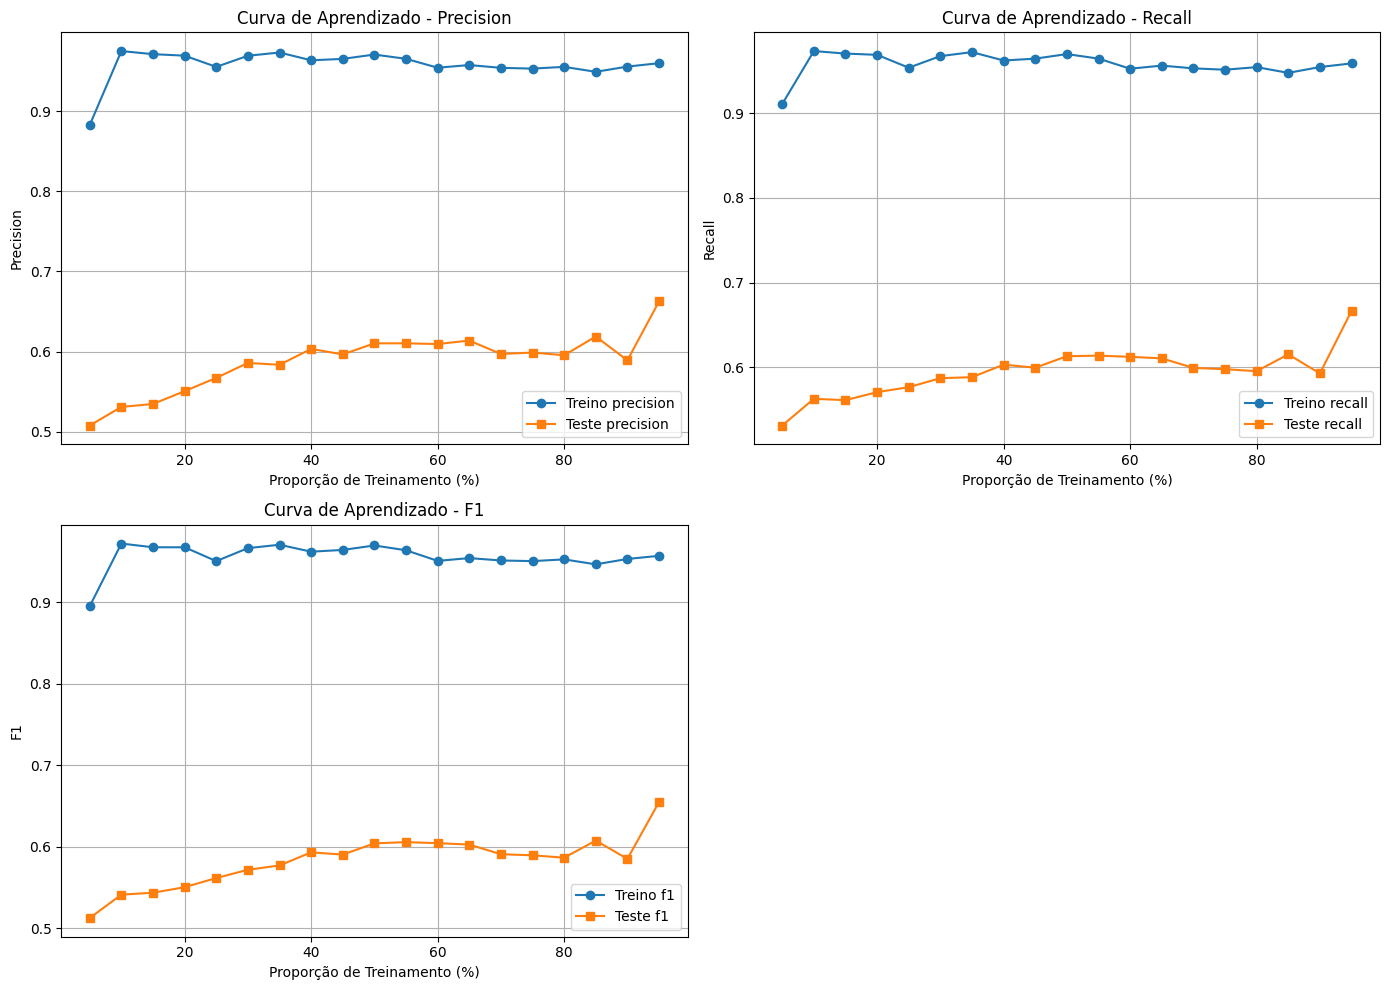

In [112]:

# Show plot 5% by 5% on x axis
plt.figure(figsize=(14, 10))
for i, metric in enumerate(metrics_train.keys()):
    plt.subplot(2, 2, i+1)
    plt.plot(train_sizes * 100, metrics_train[metric], 'o-', label=f'Treino {metric}')
    plt.plot(train_sizes * 100, metrics_test[metric], 's-', label=f'Teste {metric}')
    plt.title(f'Curva de Aprendizado - {metric.capitalize()}')
    plt.xlabel('Proporção de Treinamento (%)')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 5. Model Comparison

### 5.1 Performance Comparison Table

In [170]:
# Create comparison table with all metrics


### 5.2 Visual Comparison

In [171]:
# Bar plots comparing model performances


### 5.3 ROC Curves Comparison

In [172]:
# Plot ROC curves for all models


## 6. Cross-Validation

In [173]:
# Perform cross-validation for all models


## 7. Final Model Selection

In [174]:
# Select the best performing model


## 8. Save Best Model

In [175]:
# Save the final model using pickle or joblib


## 9. Conclusions and Recommendations

### Key findings:
- 
- 
- 

### Recommendations:
- 
- 
- 